In [2]:
import numpy as np
import cmath
import random
import matplotlib.pyplot as plt

In [3]:
def calc_distance(drone_1, drone_2):
    # 计算任意两架无人机的距离
    return np.sqrt((drone_1[0] - drone_2[0]) ** 2 + (drone_1[1] - drone_2[1]) ** 2)
    
    
def calc_angle(drone_recipient, drone_sender_1, drone_sender_2):
    # 使用余弦定理计算夹角
    a = calc_distance(drone_sender_1, drone_sender_2)
    b = calc_distance(drone_recipient, drone_sender_1)
    c = calc_distance(drone_recipient, drone_sender_2)
    return np.arccos((b**2 + c**2 - a**2) / (2 * b * c)) * 180 / np.pi

def cost(angle1, angle2):
    return np.sum(((np.array(angle1) - np.array(angle2)) * 100) ** 2)

def cost_one(angle1, angle2):
    return np.abs(angle1 - angle2) * 100

def plot_location(location):
    x = []
    y = []
    for i in location:
        x.append(i[0])
        y.append(i[1])
    plt.scatter(x, y)
    plt.show()

In [4]:
# 表1数据
drone_location_polar = [
    [0, 0],
    [100, 0],
    [98, 40.10],
    [112, 80.21],
    [105, 119.75],
    [98, 159.86],
    [112, 199.96],
    [105, 240.07],
    [98, 280.17],
    [112, 320.28]
]
# 无人机位置无偏差极坐标
drone_ideal_location_polar = [
    [0, 0],
    [100, 0],
    [100, 40],
    [100, 80],
    [100, 120],
    [100, 160],
    [100, 200],
    [100, 240],
    [100, 280],
    [100, 320]
]
drone_location_cartesian = []
drone_ideal_location_cartesian = []

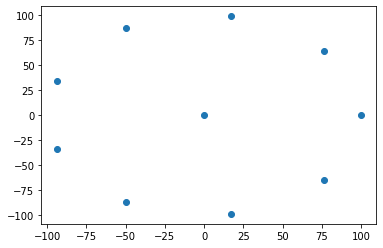

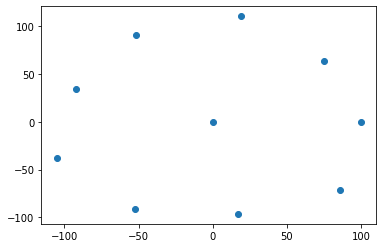

In [5]:
def polar_to_cartesian(location):
    # 极坐标转换为直角坐标
    f = np.pi / 180
    return [location[0] * np.cos(location[1] * f), location[0] * np.sin(location[1] * f)]

def cartesian_to_polar(location):
    # 直角坐标转换为极坐标
    cn = list(cmath.polar(complex(location[0], location[1])))
    cn[1] = cn[1] * 180 / np.pi
    if cn[1] < 0:
        cn[1] += 360
    return cn

drone_location_cartesian = [] # 无人机直角坐标
drone_ideal_location_cartesian = []
for location in drone_location_polar:
    drone_location_cartesian.append(polar_to_cartesian(location))

for location in drone_ideal_location_polar:
    drone_ideal_location_cartesian.append(polar_to_cartesian(location))

plot_location(drone_ideal_location_cartesian)
plot_location(drone_location_cartesian)

In [6]:
# 根据两个夹角推测位置
def get_location_from_angle(drone_id, angle, drone_sender_1, drone_sender_2, drone_sender_3):
    adjustment_range = 16
    precision = 0.5
    location_cost = []
    min_cost = 1000000
    min_cost_idx = -1
    for i in np.arange(adjustment_range * -1, adjustment_range + precision, precision):
        for i2 in np.arange(adjustment_range * -1, adjustment_range + precision, precision):
            location = list(drone_ideal_location_cartesian[drone_id])
            location[0] += i
            location[1] += i2
            cost_result = cost(
                [calc_angle(location, drone_sender_1, drone_sender_2), calc_angle(location, drone_sender_1, drone_sender_3)],
                angle
            )
            if min_cost > cost_result:
                min_cost = cost_result
                min_cost_idx = len(location_cost)
            location_cost.append([[np.round(location[0], 2), np.round(location[1], 2)], np.round(cost_result, 2)])
    return location_cost[min_cost_idx]

In [7]:
"""
假设编号为0, 1, 2的无人机发送信号，它们的位置无偏差。7号无人机的坐标有偏差，使用表1数据，根据夹角推测7号的位置

7号无人机(FY07)当前极坐标：[105, 240.07]，直角坐标[-52.38886563516721, -90.99674036722632]
调用calc_angle可得夹角分别为29.2270和9.7877度，调用get_location_from_angle推测位置
"""
drone_id = 4
angle = [calc_angle(drone_location_cartesian[drone_id], 
                    drone_ideal_location_cartesian[0], 
                    drone_ideal_location_cartesian[1]), 
         calc_angle(drone_location_cartesian[drone_id], 
                    drone_ideal_location_cartesian[0], 
                    drone_ideal_location_cartesian[2])]

location = get_location_from_angle(drone_id,
                                   angle, 
                                   drone_ideal_location_cartesian[0], 
                                   drone_ideal_location_cartesian[1], 
                                   drone_ideal_location_cartesian[2])

print(f"推测的位置, 直角坐标: {location[0]}")
print(f"实际的位置, 直角坐标: {drone_location_cartesian[drone_id]}")
print(f"推测的位置，极坐标: {cartesian_to_polar(location[0])}")
print(f"实际的位置，极坐标: {cartesian_to_polar(drone_location_cartesian[drone_id])}")

推测的位置, 直角坐标: [-52.0, 91.6]
实际的位置, 直角坐标: [-52.10273288589687, 91.16087552135994]
推测的位置，极坐标: [105.33071726709166, 119.58295300593873]
实际的位置，极坐标: [105.00000000000001, 119.75]


In [8]:
"""
Q2:
    由表1可知，FY01无人机位置无偏移，其它无人机位置有偏移。
    从FY02-FY09轮流选取一个无人机，与FY00和FY01一起，校正其它无人机的位置，重复多次。
    评价指标：其它无人机的位置与理想位置（无偏差的均匀分布在圆上）的距离之和，距离之和越小，各无人机位置越准确
"""
def adjust_location(drone_testing_location, drone_sender_id):
    distance = 0
    for i in range(1, len(drone_testing_location)):
        distance += calc_distance(drone_testing_location[i], drone_ideal_location_cartesian[i])
    print(f"调整前各无人机与理想位置的距离之和: {distance}")
    for sender_drone in range(1, len(drone_testing_location)):
        if sender_drone == drone_sender_id:
            continue
        distance = 0  # 52.0826
        for i in range(1, len(drone_testing_location)):
            if i not in [sender_drone, drone_sender_id]:
                drone_id = i
                angle = [calc_angle(drone_testing_location[drone_id], 
                                    drone_testing_location[0], 
                                    drone_testing_location[drone_sender_id]), 
                         calc_angle(drone_testing_location[drone_id], 
                                    drone_testing_location[0], 
                                    drone_testing_location[sender_drone])]

                location = get_location_from_angle(drone_id,
                                                   angle, 
                                                   drone_ideal_location_cartesian[0], 
                                                   drone_ideal_location_cartesian[drone_sender_id], 
                                                   drone_ideal_location_cartesian[sender_drone])
                drone_testing_location[i][0] += drone_ideal_location_cartesian[i][0] - location[0][0]
                drone_testing_location[i][1] += drone_ideal_location_cartesian[i][1] - location[0][1]
            distance += calc_distance(drone_testing_location[i], drone_ideal_location_cartesian[i])
        print(f"使用0, {drone_sender_id}, {sender_drone}调整无人机位置，调整后各无人机与理想位置的距离之和: {distance}")

In [9]:
drone_testing_location = []
for i in range(len(drone_location_cartesian)):
    drone_testing_location.append(list(drone_location_cartesian[i]))
    
for i in range(3):
    print(f"第 {i + 1} 次调整:")
    adjust_location(drone_testing_location, 1) # FY00, FY01发送信号

drone_testing_location_polar = []
for location in drone_testing_location:
    drone_testing_location_polar.append(cartesian_to_polar(location))

print("调整后无人机极坐标")
drone_testing_location_polar

第 1 次调整:
调整前各无人机与理想位置的距离之和: 52.08262949326125
使用0, 1, 2调整无人机位置，调整后各无人机与理想位置的距离之和: 24.12818630890338
使用0, 1, 3调整无人机位置，调整后各无人机与理想位置的距离之和: 40.49365018539801
使用0, 1, 4调整无人机位置，调整后各无人机与理想位置的距离之和: 12.131067773626928
使用0, 1, 5调整无人机位置，调整后各无人机与理想位置的距离之和: 9.448584130511987
使用0, 1, 6调整无人机位置，调整后各无人机与理想位置的距离之和: 8.659523154383413
使用0, 1, 7调整无人机位置，调整后各无人机与理想位置的距离之和: 9.029914461739626
使用0, 1, 8调整无人机位置，调整后各无人机与理想位置的距离之和: 13.459564537378633
使用0, 1, 9调整无人机位置，调整后各无人机与理想位置的距离之和: 41.26248022407574
第 2 次调整:
调整前各无人机与理想位置的距离之和: 41.26248022407574
使用0, 1, 2调整无人机位置，调整后各无人机与理想位置的距离之和: 90.77178699023608
使用0, 1, 3调整无人机位置，调整后各无人机与理想位置的距离之和: 14.12087573104153
使用0, 1, 4调整无人机位置，调整后各无人机与理想位置的距离之和: 3.5716022922104944
使用0, 1, 5调整无人机位置，调整后各无人机与理想位置的距离之和: 4.201249201709974
使用0, 1, 6调整无人机位置，调整后各无人机与理想位置的距离之和: 4.170624783153455
使用0, 1, 7调整无人机位置，调整后各无人机与理想位置的距离之和: 4.721057077119267
使用0, 1, 8调整无人机位置，调整后各无人机与理想位置的距离之和: 5.388084107763629
使用0, 1, 9调整无人机位置，调整后各无人机与理想位置的距离之和: 20.80810383062165
第 3 次调整:
调整前各无人机与理想位置的距离之和: 20.8081038306

[[0.0, 0.0],
 [100.0, 0.0],
 [99.78663507944813, 40.34301736274431],
 [99.86806014885906, 80.11447284376344],
 [99.71547608542635, 120.16268333884226],
 [98.93932276457505, 160.03330476088118],
 [99.18460167123365, 199.90900809197672],
 [99.89903253595494, 240.04015856887872],
 [100.00279475160701, 280.0230803316624],
 [99.95545778906592, 320.1525368003248]]

In [10]:
def calc_all_distance(drone_testing_location):
    distance = 0
    for i in range(1, len(drone_testing_location)):
         distance += calc_distance(drone_testing_location[i], drone_ideal_location_cartesian[i])
    return distance

def q3_adjust_location(drone_testing_location, drone_sender_1, drone_sender_2, drone_sender_3, drone_recipient):
    print(f"校准前: {calc_all_distance(drone_testing_location)}")
    adjustment_range = 8
    precision = 1
    for drone_id in drone_recipient:
        location_cost = []
        min_cost = 1000000
        min_cost_idx = -1
        for i in np.arange(adjustment_range * -1, adjustment_range + precision, precision):
            for i2 in np.arange(adjustment_range * -1, adjustment_range + precision, precision):
                location = list(drone_testing_location[drone_id])
                location[0] += i
                location[1] += i2
                angle = [calc_angle(location, drone_testing_location[drone_sender_1], drone_testing_location[drone_sender_2]), 
                         calc_angle(location, drone_testing_location[drone_sender_1], drone_testing_location[drone_sender_3])]
                angle_cost = cost(angle,
                                 [calc_angle(drone_ideal_location_cartesian[drone_id], drone_testing_location[drone_sender_1], drone_testing_location[drone_sender_2]), 
                                  calc_angle(drone_ideal_location_cartesian[drone_id], drone_testing_location[drone_sender_1], drone_testing_location[drone_sender_3])])
                if angle_cost < min_cost:
                    min_cost = angle_cost
                    min_cost_idx = len(location_cost)
                location_cost.append([location, angle])
        drone_testing_location[drone_id] = location_cost[min_cost_idx][0]
    print(f"校准后: {calc_all_distance(drone_testing_location)}")

def q3_adjust_first_column(drone_testing_location):
    adjustment_range = 8
    precision = 0.1
    for drone_id in [2, 3, 4]:
        location_cost = []
        min_cost = 1000000
        min_cost_idx = -1
        for i in np.arange(adjustment_range * -1, adjustment_range + precision, precision):
            location = list(drone_testing_location[drone_id])
            location[0] += i
            angle = calc_angle(location, drone_testing_location[0], drone_testing_location[1])
            if angle < min_cost:
                min_cost = angle
                min_cost_idx = len(location_cost)
            location_cost.append([location, angle])
        drone_testing_location[drone_id] = location_cost[min_cost_idx][0]

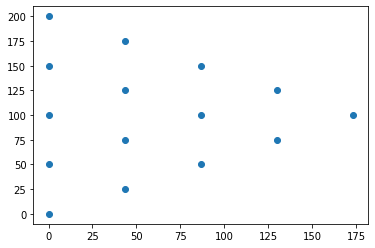

In [11]:
"""
问题2
以FY15为原点，建立极坐标系
0: FY15
1: FY14
2: FY13
3: FY12
4: FY11
5: FY10
.
.
.
14: FY01
"""
# 无人机如锥形编队位置无偏差直角
x = np.sqrt(50**2-25**2)
drone_ideal_location_cartesian = [
    # 第1列
    [0, 0],
    [0, 50],
    [0, 100],
    [0, 150],
    [0, 200],
    # 第2列
    [x, 25],
    [x, 75],
    [x, 125],
    [x, 175],
    # 第3列
    [2 * x, 50],
    [2 * x, 100],
    [2 * x, 150],
    # 第4列
    [3 * x, 75],
    [3 * x, 125],
    # 第5列
    [4 * x, 100]
    
]
plot_location(drone_ideal_location_cartesian)

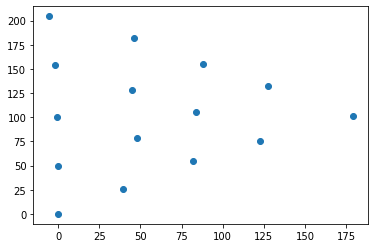

In [12]:
# 除了FY14和FY15，给其它无人机位置添加随机偏移
drone_location_cartesian = []
for i in range(len(drone_ideal_location_cartesian)):
    location = drone_ideal_location_cartesian[i]
    drone_location_cartesian.append(list(location))
    if i in [0, 1]:
        continue
    if random.random() >= 0.5:
        drone_location_cartesian[i][0] = location[0] + random.random() * 8
    else:
        drone_location_cartesian[i][0] = location[0] - random.random() * 8
    if random.random() >= 0.5:
        drone_location_cartesian[i][1] = location[1] + random.random() * 8
    else:
        drone_location_cartesian[i][1] = location[1] + random.random() * 8

plot_location(drone_location_cartesian)

In [13]:
drone_testing_location = []
for i in range(len(drone_location_cartesian)):
    drone_testing_location.append(list(drone_location_cartesian[i]))
distance = 0
for i in range(1, len(drone_testing_location)):
     distance += calc_distance(drone_testing_location[i], drone_ideal_location_cartesian[i])
distance

73.09169306116219

根据FY14和FY15，先校准第一列的x轴坐标，让第一列对齐


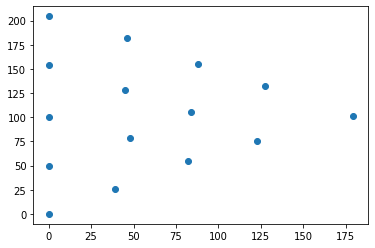

根据第一列的FY13、FY14和FY15，校准第二列
校准前: 69.54192448770553
校准后: 51.18221743746535


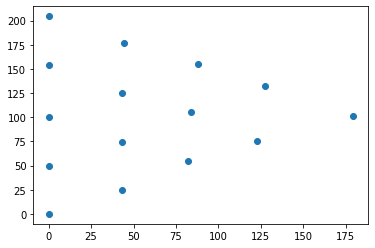

根据第二列FY08、FY09和FY10，校准第一列
校准前: 51.18221743746535
校准后: 46.26377976139222


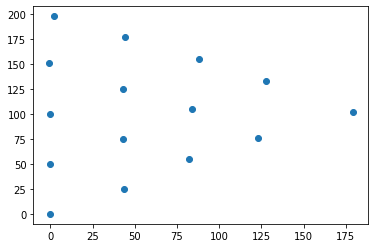

再次让第一列与FY15对齐


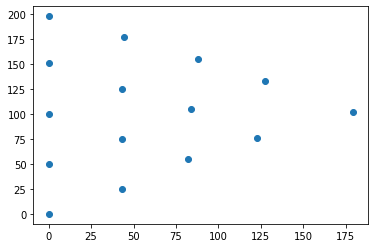

据FY13、FY14和FY15，校准其余无人机
校准前: 44.84730891980404
校准后: 9.18461090861045


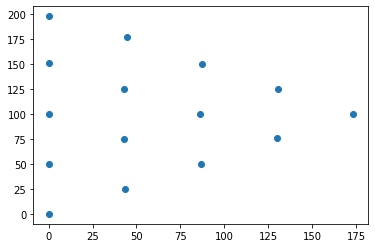

In [14]:
# 根据FY14和FY15，先校准第一列的x轴坐标，让第一列对齐
print("根据FY14和FY15，先校准第一列的x轴坐标，让第一列对齐")
q3_adjust_first_column(drone_testing_location)
plot_location(drone_testing_location)

# 根据第一列的FY13、FY14和FY15，校准第二列
print("根据第一列的FY13、FY14和FY15，校准第二列")
q3_adjust_location(drone_testing_location, 0, 1, 2, range(5, 9))
plot_location(drone_testing_location)

# 根据第二列FY08、FY09和FY10，校准第一列
print("根据第二列FY08、FY09和FY10，校准第一列")
q3_adjust_location(drone_testing_location, 5, 6, 7, [1, 2, 3, 4])
plot_location(drone_testing_location)

# 再次让第一列与FY15对齐
print("再次让第一列与FY15对齐")
q3_adjust_first_column(drone_testing_location)
plot_location(drone_testing_location)

# 根据FY13、FY14和FY15，校准其余无人机
print("据FY13、FY14和FY15，校准其余无人机")
q3_adjust_location(drone_testing_location, 0, 1, 2, range(5, 15))
plot_location(drone_testing_location)